In [78]:
from scipy.io import netcdf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gsw
sns.set(context='talk',style='whitegrid',font_scale=1.3)
#from model_plotting import plot_snapshot,plot_snapshot_w
import scipy.linalg as la
# from spectra_module import spec2d

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from deformtools.tools import alphabet

sns.set(style='ticks', context='paper', palette='colorblind',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

/usr/local/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [15]:
dirr.split('/')[-1].split('_')[1].split('.')[0]

'08325'

In [16]:
zgrid = pd.read_csv('../data/psom/zgrid.out',skipinitialspace=True,sep=' ',header=None)
zgrid=zgrid[1].values

dirr='../data/psom/full_08325.cdf'
time = dirr.split('/')[-1].split('_')[1].split('.')[0]

f =  netcdf.netcdf_file(dirr, 'r')
u = f.variables['u'][:][33, 1:321, 1:193]
v= f.variables['v'][:][33, 1:321, 1:193]
vor= f.variables['vor'][:][33, 1:321, 1:193]/gsw.f(17)
xc = f.variables['xc'][1:193]
yc = f.variables['yc'][1:321]

In [18]:
#%%
import random
import math

def make_hex(x0,y0,L,skew):
    i=0
    xx=np.zeros(M)
    yy=np.zeros(M)
    
    degstart = random.randint(0,360)
    angle = np.arange(degstart,degstart+360,360//M)
    angle[angle>360] = angle[angle>360]-360 
    
    random_stretch = random.randint(0,2)
    for j,angle in enumerate( angle ):
        if j==random_stretch:
            alpha=skew
        else:
            alpha=1
        xx[i] = x0 + alpha*L*math.cos(math.radians(angle))
        yy[i] = y0 + alpha*L*math.sin(math.radians(angle))
        i+=1
        
    return xx,yy

def make_n_hexs(L,skew):
    x=np.zeros((N,M))
    y=np.zeros((N,M))
    for i in range(N):
        x0=(180-10)*random.random() + 10
        y0=(300-10)*random.random() + 10
        x[i,:],y[i,:] = make_hex(x0,y0,L,skew)
    return x,y

def least_square_method(x0,y0,u0,v0,switch):
    ncc = x0.size
     
    dlon=np.zeros(ncc)  
    dlat=np.zeros(ncc)  
    for i in range(ncc):
        dlon[i] =  (x0[i] - np.nanmean(x0))*1000
        # should be distance in m in x from COM
        dlat[i] =  (y0[i]-np.nanmean(y0))*1000
    f=gsw.f(17)
    
    R = np.mat( np.vstack( (np.ones((ncc,)) ,dlon, dlat) ).T )
    u0=np.mat(u0).T - np.nanmean(u0)
    v0=np.mat(v0).T - np.nanmean(v0)
    
    if switch==0:
        A,_,_,_=la.lstsq(R,u0)
        B,_,_,_=la.lstsq(R,v0)
    elif switch==1:
        A = np.linalg.inv(R.T*R)*R.T*u0
        B = np.linalg.inv(R.T*R)*R.T*v0
    else:
        A=np.linalg.solve(R,u0)
        B=np.linalg.solve(R,v0)
        
    vort = (B[1]-A[2])/f
    strain = np.sqrt( (A[1]-B[2])**2 + (B[1]+A[2])**2 ) /f
    div = ( A[1]+B[2] )/f

    return vort,strain,div

In [19]:
L=2
N = 10000
M=3
xi,yi = make_n_hexs(L,0)

#%%
from scipy import interpolate
meth='cubic'
xx,yy= np.meshgrid(xc,yc)

In [20]:
fu = interpolate.RectBivariateSpline(yc,xc,u)
fv = interpolate.RectBivariateSpline(yc,xc,v)
fzeta = interpolate.RectBivariateSpline(yc,xc,vor)

In [21]:
import bottleneck as bn
vortia=np.zeros(N)
vortib=np.zeros(N)

In [22]:
#%%
ui=np.zeros((N,M))
vi=np.zeros((N,M))
zetai=np.zeros((N,M))
zeta_at_mean = np.zeros(N)
for i in range(N):
    for j in range(xi[1,:].size):
        ui[i,j] = fu(yi[i,j],xi[i,j])
        vi[i,j] = fv(yi[i,j],xi[i,j])
        zetai[i,j] = fzeta(yi[i,j],xi[i,j])
    zeta_at_mean[i]=  fzeta( np.mean(yi[i]),np.mean(xi[i]) )

In [23]:
vort_drifters=np.zeros(N)
for i in range(N):
    vort_drifters[i],_,_=least_square_method(xi[i,:],yi[i,:],ui[i,:],vi[i,:],2)
    
df_comparison = pd.DataFrame({'model_zeta':zeta_at_mean,'drifter_zeta':vort_drifters},index=np.arange(N))

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


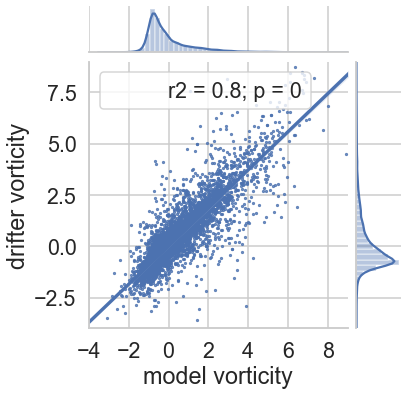

In [24]:
# model vs true
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2,stats.pearsonr(x, y)[1]
g=sns.jointplot(x='model_zeta',y='drifter_zeta',data=df_comparison,
              kind='reg',stat_func=r2,scatter_kws={"s": 5})
plt.xlabel('model vorticity')
plt.ylabel('drifter vorticity')

g.ax_joint.set_xticks([-4,-2,0,2,4,6,8])
g.ax_joint.set_xlim([-4,9])
g.ax_joint.set_ylim([-4,9])
#g.ax_joint.set_yticks([-2,-1,0,1,2,3,4,5])
plt.savefig('performance.pdf',bb_inches='tight',dpi=600)
plt.show()

In [25]:
from scipy.ndimage import gaussian_filter

In [49]:
mode ='constant'
vor_5km = gaussian_filter(vor,sigma=5,mode=mode)
u_5km = gaussian_filter(u,sigma=5,mode=mode)
v_5km = gaussian_filter(v,sigma=5,mode=mode)
vor_10km = gaussian_filter(vor,sigma=10,mode=mode)
u_10km = gaussian_filter(u,sigma=10,mode=mode)
v_10km = gaussian_filter(v,sigma=10,mode=mode)

In [50]:
# vorhat,bin_cents = spec2d(vor,logspacing=True,return_freqs=True,binsize=12)
# vor5hat,bin_cents = spec2d(vor_5km,logspacing=True,return_freqs=True,binsize=12)
# vor10hat,bin_cents = spec2d(vor_10km,logspacing=True,return_freqs=True,binsize=12)

In [51]:
# f,ax=plt.subplots(1,1,figsize=(10,10))

# vorhat[vorhat<1e1]=np.nan
# vor5hat[vor5hat<1e1]=np.nan
# vor10hat[vor10hat<1e1]=np.nan

# ax.plot(bin_cents,bin_cents*vorhat,label='1km')
# ax.plot(bin_cents,bin_cents*vor5hat,label='5km')
# ax.plot(bin_cents,bin_cents*vor10hat,label='10km')

# ax.axvline(1/1 )
# ax.axvline(1/2 )
# ax.axvline(2*np.pi/4 )
# ax.set_xscale('log',basex=10)


# plt.show()

In [52]:
fu = interpolate.RectBivariateSpline(yc,xc,u)
fv = interpolate.RectBivariateSpline(yc,xc,v)
fzeta = interpolate.RectBivariateSpline(yc,xc,vor)
# 10km
fu5 = interpolate.RectBivariateSpline(yc,xc,u_5km)
fv5 = interpolate.RectBivariateSpline(yc,xc,v_5km)
fzeta5 = interpolate.RectBivariateSpline(yc,xc,vor_5km)
# 20km
fu10 = interpolate.RectBivariateSpline(yc,xc,u_10km)
fv10 = interpolate.RectBivariateSpline(yc,xc,v_10km)
fzeta10 = interpolate.RectBivariateSpline(yc,xc,vor_10km)

In [53]:
#%%
ui=np.zeros((N,M))
vi=np.zeros((N,M))
ui5=np.zeros((N,M))
vi5=np.zeros((N,M))
ui10=np.zeros((N,M))
vi10=np.zeros((N,M))
zeta_at_mean = np.zeros(N)
zeta_at_mean5 = np.zeros(N)
zeta_at_mean10 = np.zeros(N)
for i in range(N):
    for j in range(xi[1,:].size):
        ui[i,j] = fu(yi[i,j],xi[i,j])
        vi[i,j] = fv(yi[i,j],xi[i,j])
        ui5[i,j] = fu5(yi[i,j],xi[i,j])
        vi5[i,j] = fv5(yi[i,j],xi[i,j])
        ui10[i,j] = fu10(yi[i,j],xi[i,j])
        vi10[i,j] = fv10(yi[i,j],xi[i,j])
    zeta_at_mean[i]=  fzeta( np.mean(yi[i]),np.mean(xi[i]) )
    zeta_at_mean5[i]=  fzeta5( np.mean(yi[i]),np.mean(xi[i]) )
    zeta_at_mean10[i]=  fzeta10( np.mean(yi[i]),np.mean(xi[i]) )

In [54]:
vort_drifters=np.zeros(N)
vort_drifters5=np.zeros(N)
vort_drifters10=np.zeros(N)
for i in range(N):
    vort_drifters[i],_,_=least_square_method(xi[i,:],yi[i,:],ui[i,:],vi[i,:],2)
    vort_drifters10[i],_,_=least_square_method(xi[i,:],yi[i,:],ui5[i,:],vi5[i,:],2)
    vort_drifters20[i],_,_=least_square_method(xi[i,:],yi[i,:],ui10[i,:],vi10[i,:],2)

In [55]:
df_comparison = pd.DataFrame({'model_zeta':zeta_at_mean,'drifter_zeta':vort_drifters,
                             'model_zeta10':zeta_at_mean10,'drifter_zeta10':vort_drifters10,
                             'model_zeta20':zeta_at_mean20,'drifter_zeta20':vort_drifters20},index=np.arange(N) )

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


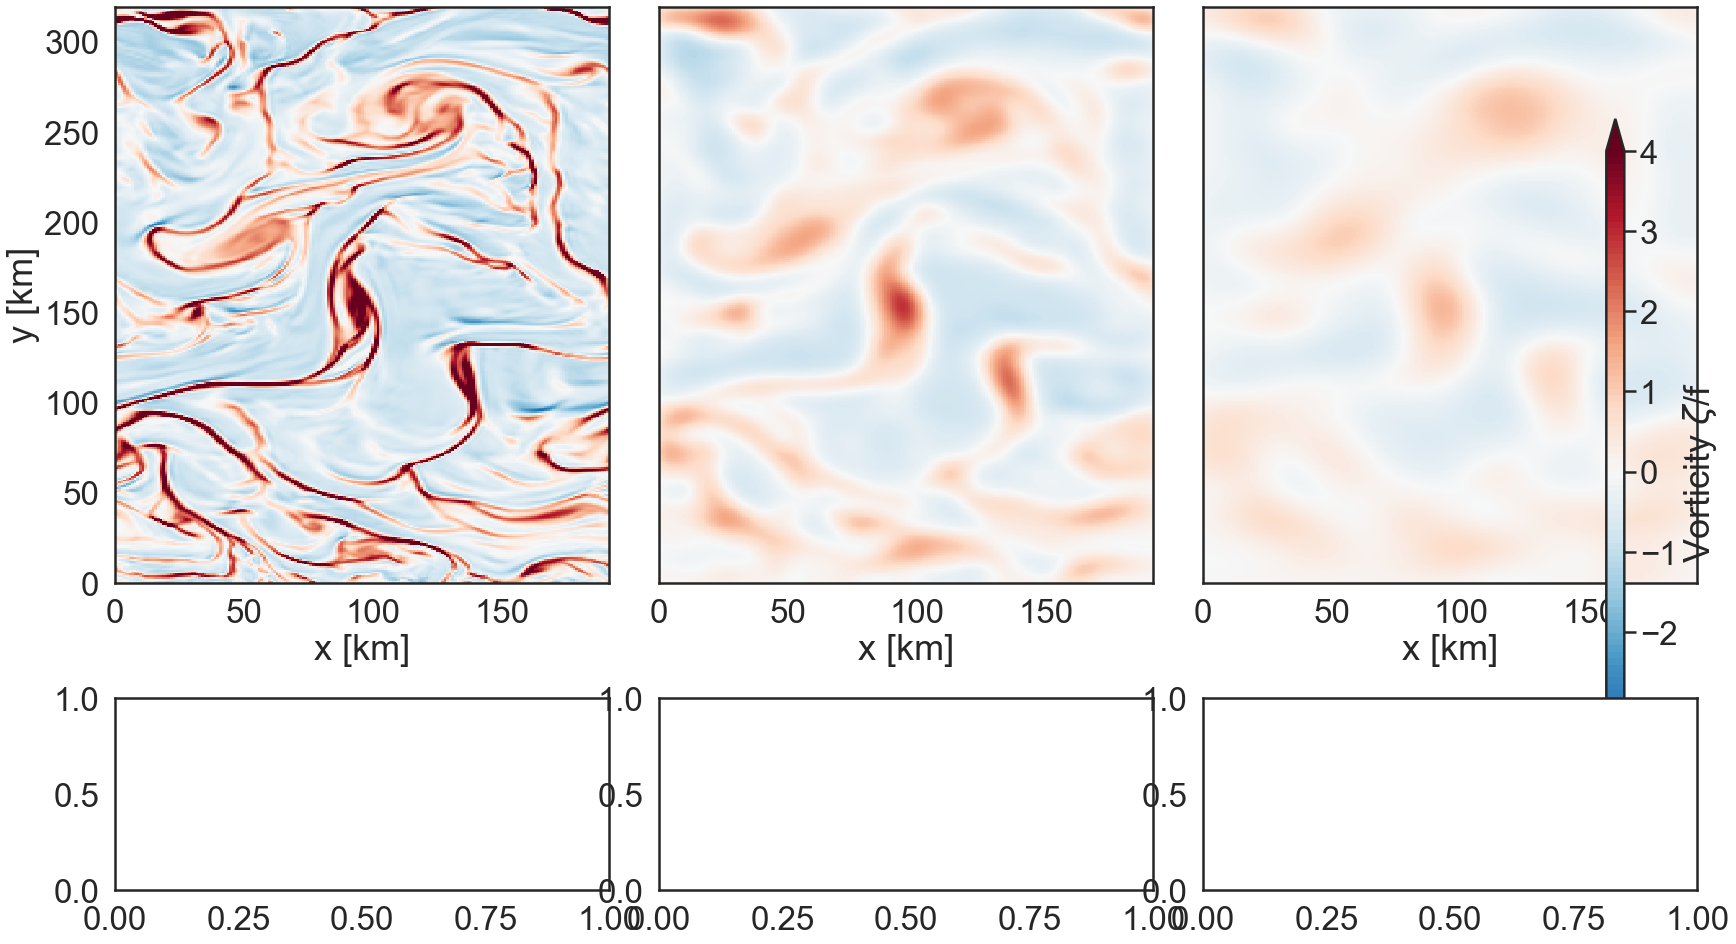

In [76]:
f = plt.figure(figsize=(25,14))
widths = [1,1,1]
heights = [3,1]
spec = f.add_gridspec(ncols=3,
                      nrows=2,
                      width_ratios=widths,
                      height_ratios=heights)

ax1 = f.add_subplot(spec[0, 0])
ax2 = f.add_subplot(spec[0, 1], sharey=ax1)
ax3 = f.add_subplot(spec[0, 2], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

ax1.pcolormesh(xc, yc, vor, cmap='RdBu_r',rasterized=True, vmin=-4,vmax=4)
ax2.pcolormesh(xc, yc, vor_5km, cmap='RdBu_r',rasterized=True, vmin=-4,vmax=4)
ax3.pcolormesh(xc, yc, vor_10km, cmap='RdBu_r',rasterized=True, vmin=-4,vmax=4)
ax1.set_yticks(np.arange(0,305,50))
ax1.set_xticks(np.arange(0,155,50))
ax2.set_xticks(np.arange(0,155,50))
ax3.set_xticks(np.arange(0,155,50))
ax1.set_ylabel('y [km]')
ax1.set_xlabel('x [km]')
ax2.set_xlabel('x [km]')
ax3.set_xlabel('x [km]')

a = ax3.get_position()
cbar_ax = f.add_axes([a.bounds[0]+a.bounds[2]+0.01, 0.15, 0.01, 0.7]) #
cbar = f.colorbar(h3, cax=cbar_ax,ticks=np.arange(-4,5),label='Vorticity $\zeta$/f')
cbar.ax.set_xticklabels(np.arange(-4,5))

ax4 = f.add_subplot(spec[1, 0])
ax5 = f.add_subplot(spec[1, 1])
ax6 = f.add_subplot(spec[1, 2])

spec.tight_layout(f)
spec.update(hspace=0.3,wspace=0.1)

plt.savefig('../figures/vorticity_filtered.pdf',bb_inches='tight',dpi=600)

In [84]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2,stats.pearsonr(x, y)[1]


def plot_joint(ax,x,y,data):
    g=sns.jointplot(x=x,y=y,data=data,size=8.5,
                  kind='reg',stat_func=None,scatter_kws={"s": 5},ax=ax,)
    g.annotate(r2,template = "{stat} = {val:.3f} (p = {p:.3f})")
    plt.xlabel('model vorticity $\zeta$/f')
    plt.ylabel('drifter vorticity $\zeta$/f')

    g.ax_joint.set_xticks([-4,-2,0,2,4,6,8])
    g.ax_joint.set_xlim([-4,8])
    g.ax_joint.set_ylim([-4,8])
    #g.ax_joint.set_yticks([-2,-1,0,1,2,3,4,5])
#     plt.savefig('performance_1km.pdf',bb_inches='tight',dpi=400)
    plt.show()

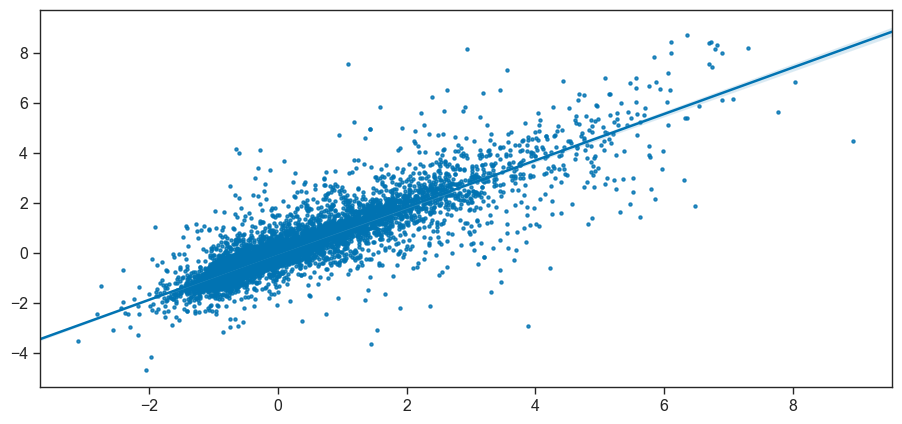

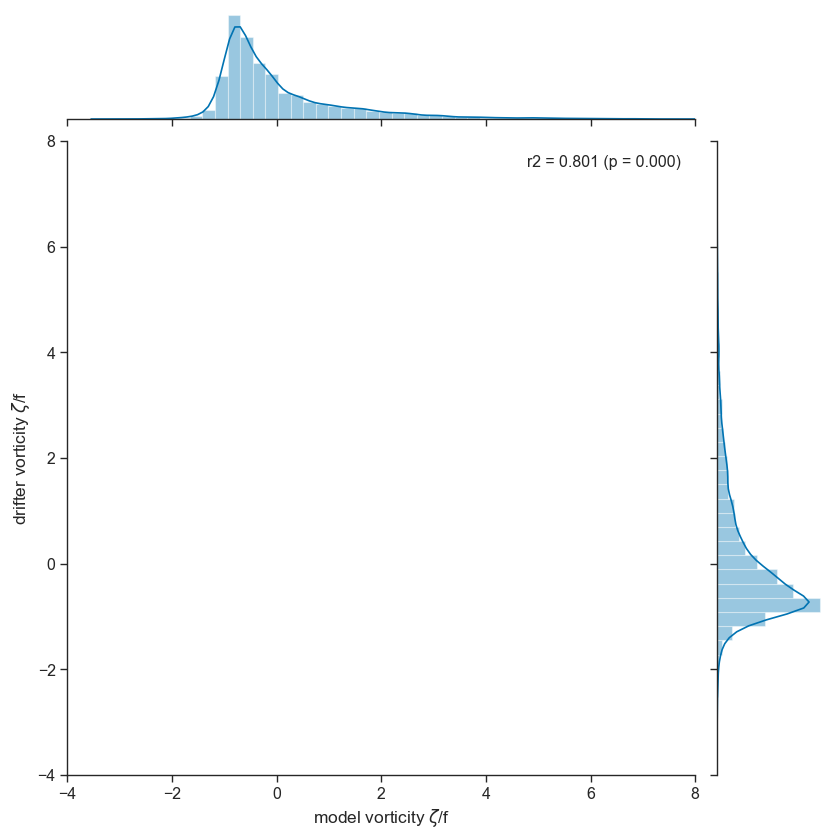

In [85]:
f,ax = plt.subplots(1,1)
plot_joint(ax,'model_zeta','drifter_zeta',df_comparison)

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


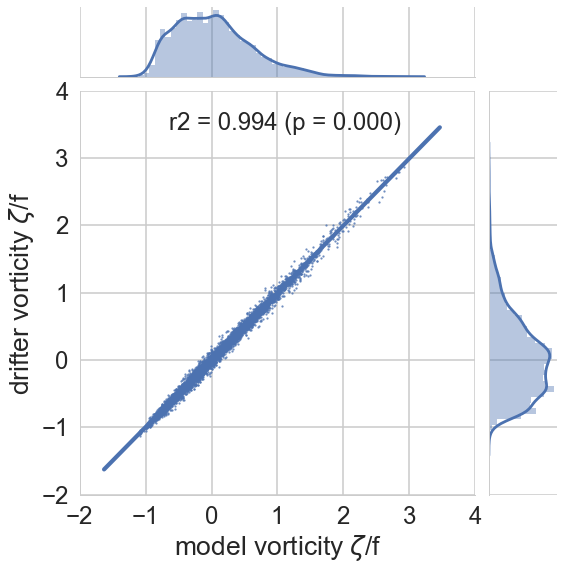

In [264]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2,stats.pearsonr(x, y)[1]
g=sns.jointplot(x='model_zeta10',y='drifter_zeta10',data=df_comparison,size=8.5,
              kind='reg',stat_func=None,scatter_kws={"s": 5})
g.annotate(r2,template = "{stat} = {val:.3f} (p = {p:.3f})")
plt.xlabel('model vorticity $\zeta$/f')
plt.ylabel('drifter vorticity $\zeta$/f')

g.ax_joint.set_xticks([-2,-1,0,1,2,3,4])
g.ax_joint.set_xlim([-2,4])
g.ax_joint.set_ylim([-2,4])
#g.ax_joint.set_yticks([-2,-1,0,1,2,3,4,5])
plt.savefig('performance_5km.pdf',bb_inches='tight',dpi=400)
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


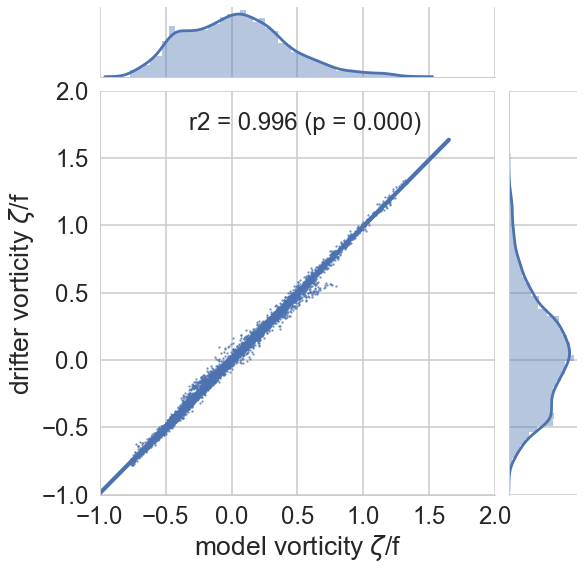

In [265]:
sns.set(context='poster',style='whitegrid',font_scale=1.5)
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2,stats.pearsonr(x, y)[1]
g=sns.jointplot(x='model_zeta20',y='drifter_zeta20',data=df_comparison,size=8.5,
              kind='reg',stat_func=None,scatter_kws={"s": 5})

g.annotate(r2,template = "{stat} = {val:.3f} (p = {p:.3f})")
plt.xlabel('model vorticity $\zeta$/f')
plt.ylabel('drifter vorticity $\zeta$/f')

g.ax_joint.set_xticks([-1,-0.5,0,0.5,1,1.5,2])
g.ax_joint.set_xlim([-1,2])
g.ax_joint.set_ylim([-1,2])
#g.ax_joint.set_yticks([-2,-1,0,1,2,3,4,5])
plt.savefig('performance_10km.pdf',bb_inches='tight',dpi=400)
plt.show()